<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a><br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Market Cap vs Dollar Volume

## Run Pipeline

In [1]:
from zipline.pipeline import sharadar, master, Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.research import run_pipeline, use_bundle

In [2]:
use_bundle("sharadar-1d")

marketcap = sharadar.Fundamentals.slice("ART").MARKETCAP.latest
dollar_volume = AverageDollarVolume(window_length=30)

universe = dollar_volume.notnull() & marketcap.notnull()

pipeline = Pipeline(
    columns={
        "market_cap_rank": marketcap.rank(mask=universe),
        "dollar_volume_rank": dollar_volume.rank(mask=universe),
        "dollar_volume_decile": dollar_volume.deciles(mask=universe),
        "market_cap_decile": marketcap.deciles(mask=universe),
        "stock_type": master.SecuritiesMaster.sharadar_Category.latest,
        "name": master.SecuritiesMaster.sharadar_Name.latest
    },
    screen=universe
)

In [3]:
results = run_pipeline(pipeline, start_date="2023-08-22", end_date="2023-08-22")

## How far apart are a stock's market cap decile and dollar volume decile?

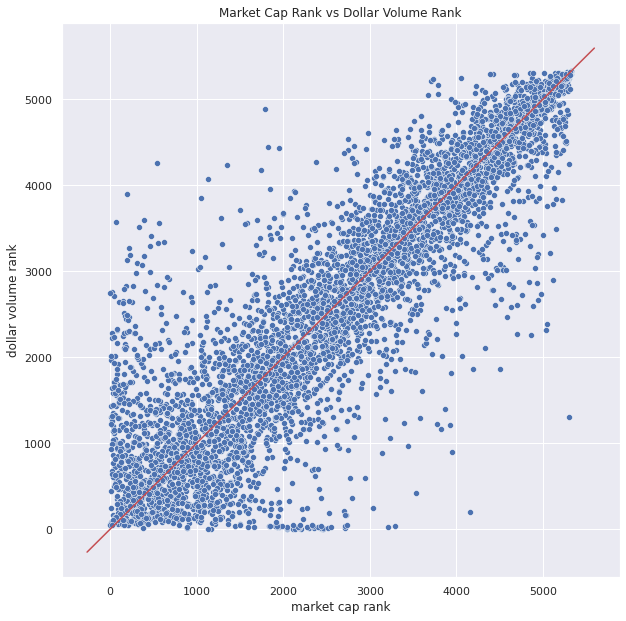

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=results, x="market_cap_rank", y="dollar_volume_rank", ax=ax)
ax.set_title("Market Cap Rank vs Dollar Volume Rank")
ax.set_ylabel("dollar volume rank")
ax.set_xlabel("market cap rank");
# Add a regression line with slope 1 and y-intercept 0
ax.plot(ax.get_xlim(), ax.get_ylim(), 'r-');

## Distribution of Top Market Cap Decile and Top Dollar Volume Decile

How are stocks in the top market cap decile distributed across dollar volume deciles? And how are stocks in the top dollar volume decile distributed across market cap deciles?

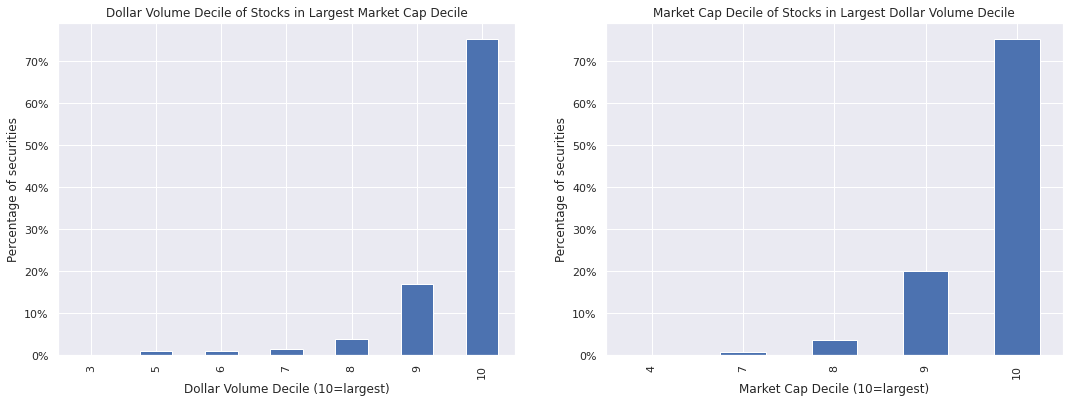

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

counts = results[results.market_cap_decile==9].groupby('dollar_volume_decile')['name'].count()
counts.name = ""
counts.index += 1
counts.index.name = "Dollar Volume Decile (10=largest)"
counts = counts / counts.sum()
counts.sort_index().plot(kind="bar", ax=axes[0], title="Dollar Volume Decile of Stocks in Largest Market Cap Decile");

counts = results[results.dollar_volume_decile==9].groupby('market_cap_decile')['name'].count()
counts.name = ""
counts.index += 1
counts.index.name = "Market Cap Decile (10=largest)"
counts = counts / counts.sum()
counts.sort_index().plot(kind="bar", ax=axes[1], title="Market Cap Decile of Stocks in Largest Dollar Volume Decile");

for ax in axes:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel("Percentage of securities")

## What kinds of stocks have low dollar volume but high market cap?

Mostly ADRs.

In [6]:
high_mc_low_dv = results[(results.market_cap_decile==9) & (results.dollar_volume_decile < 9)].sort_values("dollar_volume_decile")
high_mc_low_dv.groupby('stock_type', observed=True).name.count()

stock_type
ADR Common Stock                       47
ADR Common Stock Primary Class         13
Canadian Common Stock                  17
Canadian Common Stock Primary Class     2
Domestic Common Stock                  37
Domestic Common Stock Primary Class    15
Name: name, dtype: int64

## What kinds of stocks have low market cap but high dollar volume?

Popular retail/meme stocks like Tupperware, Nikola, and Affirm.

In [7]:
high_dv_low_mc = results[(results.dollar_volume_decile==9) & (results.market_cap_decile < 9)].sort_values("market_cap_decile")
high_dv_low_mc[['name', 'market_cap_decile']].head(10)

name  \
date       asset                                                          
2023-08-22 Equity(FIBBG000GQ1G25 [TUP])          TUPPERWARE BRANDS CORP   
           Equity(FIBBG000BRQ6L2 [JBLU])           JETBLUE AIRWAYS CORP   
           Equity(FIBBG00L4CWQ45 [NKLA])                    NIKOLA CORP   
           Equity(FIBBG001K7WBT8 [MARA])  MARATHON DIGITAL HOLDINGS INC   
           Equity(FIBBG00PQ4XJ45 [RXRX])  RECURSION PHARMACEUTICALS INC   
           Equity(FIBBG00Y7BP8Y1 [AFRM])            AFFIRM HOLDINGS INC   
           Equity(FIBBG000BQ4512 [RIOT])             RIOT PLATFORMS INC   
           Equity(FIBBG00XJDVWJ3 [DEN])                     DENBURY INC   
           Equity(FIBBG002293PJ4 [RH])                               RH   
           Equity(FIBBG000BLW102 [COHR])                  COHERENT CORP   

                                          market_cap_decile  
date       asset                                             
2023-08-22 Equity(FIBBG000GQ1G25 [TUP])                   3  
           Equity(FIBBG000BRQ6L2 [JBLU])                  6  
           Equity(FIBBG00L4CWQ45 [NKLA])                  6  
           Equity(FIBBG001K7WBT8 [MARA])                  6  
           Equity(FIBBG00PQ4XJ45 [RXRX])                  6  
           Equity(FIBBG00Y7BP8Y1 [AFRM])                  7  
           Equity(FIBBG000BQ4512 [RIOT])                  7  
           Equity(FIBBG00XJDVWJ3 [DEN])                   7  
           Equity(FIBBG002293PJ4 [RH])                    7  
           Equity(FIBBG000BLW102 [COHR])                  7